<a href="https://colab.research.google.com/github/w2k31984/ChallengeIII_Analisis-de-evasion-de-Clientes-TelecomX/blob/master/telecom_churn_analysis_cristianParada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Telecom X - Análisis de Evasión de Clientes (Churn Analysis)

## 🎯 Introducción

**Objetivo del Análisis:** Comprender los factores que llevan a la pérdida de clientes en Telecom X y proporcionar insights valiosos para reducir la tasa de evasión.

**Problema:** Telecom X enfrenta una alta tasa de cancelaciones y necesita identificar patrones y tendencias en el comportamiento de los clientes para desarrollar estrategias efectivas de retención.

**Metodología:** Aplicaremos técnicas de ETL (Extracción, Transformación y Carga), análisis exploratorio de datos (EDA) y visualizaciones estratégicas para extraer información valiosa del dataset.

---


## 📚 Importación de Bibliotecas


In [10]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from collections import Counter

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Bibliotecas importadas exitosamente")


✅ Bibliotecas importadas exitosamente


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📂 Extracción de Datos desde la API


In [12]:
# Cargar los datos desde el archivo JSON local
# Nota: Los datos ya están disponibles localmente desde el repositorio de GitHub
with open('/content/drive/MyDrive/Data_Science/Creacion_Modelo_Predictivo_ML_DS4B/Challenge_TelecomX/TelecomX_Data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

print(f"✅ Datos cargados exitosamente")
print(f"📊 Total de registros: {len(data)}")
print(f"📋 Primeros 2 registros:")
for i in range(2):
    print(f"Cliente {i+1}: {data[i]['customerID']}")

# Verificar estructura de un registro para entender el problema
print(f"\n🔍 Estructura de datos del primer registro:")
print(f"Charges del primer registro: {data[0]['account']['Charges']}")

# Verificar algunos TotalCharges para encontrar valores problemáticos
print(f"\n🔍 Valores de TotalCharges en los primeros 10 registros:")
for i in range(10):
    total_charges = data[i]['account']['Charges']['Total']
    print(f"Cliente {i+1}: '{total_charges}' (tipo: {type(total_charges)})")


✅ Datos cargados exitosamente
📊 Total de registros: 7267
📋 Primeros 2 registros:
Cliente 1: 0002-ORFBO
Cliente 2: 0003-MKNFE

🔍 Estructura de datos del primer registro:
Charges del primer registro: {'Monthly': 65.6, 'Total': '593.3'}

🔍 Valores de TotalCharges en los primeros 10 registros:
Cliente 1: '593.3' (tipo: <class 'str'>)
Cliente 2: '542.4' (tipo: <class 'str'>)
Cliente 3: '280.85' (tipo: <class 'str'>)
Cliente 4: '1237.85' (tipo: <class 'str'>)
Cliente 5: '267.4' (tipo: <class 'str'>)
Cliente 6: '571.45' (tipo: <class 'str'>)
Cliente 7: '7904.25' (tipo: <class 'str'>)
Cliente 8: '5377.8' (tipo: <class 'str'>)
Cliente 9: '340.35' (tipo: <class 'str'>)
Cliente 10: '5957.9' (tipo: <class 'str'>)


## 🔄 Transformación de Datos a DataFrame


In [13]:
# Función auxiliar para convertir valores numéricos de forma segura
def safe_float_conversion(value, default=0.0):
    """
    Convierte un valor a float de forma segura, manejando casos especiales.

    Args:
        value: El valor a convertir
        default: Valor por defecto si la conversión da error.

    Returns:
        float: El valor convertido o el valor por defecto.
    """
    try:
        # Si es string, limpiar espacios en blanco
        if isinstance(value, str):
            value = value.strip()
            # Si es string vacío, devolver default
            if value == '' or value == ' ':
                return default

        # Intentar conversión
        return float(value)
    except (ValueError, TypeError):
        # Si falla la conversión, devolver default
        return default

# Función para aplanar la estructura JSON anidada (CORREGIDA)
def flatten_customer_data(customer_record):
    flat_record = {}

    # Información básica
    flat_record['customerID'] = customer_record['customerID']
    flat_record['Churn'] = customer_record['Churn']

    # Información del cliente
    customer_info = customer_record['customer']
    flat_record['gender'] = customer_info['gender']
    flat_record['SeniorCitizen'] = customer_info['SeniorCitizen']
    flat_record['Partner'] = customer_info['Partner']
    flat_record['Dependents'] = customer_info['Dependents']
    flat_record['tenure'] = customer_info['tenure']

    # Servicios telefónicos
    phone_info = customer_record['phone']
    flat_record['PhoneService'] = phone_info['PhoneService']
    flat_record['MultipleLines'] = phone_info['MultipleLines']

    # Servicios de internet
    internet_info = customer_record['internet']
    flat_record['InternetService'] = internet_info['InternetService']
    flat_record['OnlineSecurity'] = internet_info['OnlineSecurity']
    flat_record['OnlineBackup'] = internet_info['OnlineBackup']
    flat_record['DeviceProtection'] = internet_info['DeviceProtection']
    flat_record['TechSupport'] = internet_info['TechSupport']
    flat_record['StreamingTV'] = internet_info['StreamingTV']
    flat_record['StreamingMovies'] = internet_info['StreamingMovies']

    # Información de cuenta (CORREGIDA para manejar valores faltantes)
    account_info = customer_record['account']
    flat_record['Contract'] = account_info['Contract']
    flat_record['PaperlessBilling'] = account_info['PaperlessBilling']
    flat_record['PaymentMethod'] = account_info['PaymentMethod']

    # Usar conversión segura para valores numéricos
    flat_record['MonthlyCharges'] = safe_float_conversion(account_info['Charges']['Monthly'])
    flat_record['TotalCharges'] = safe_float_conversion(account_info['Charges']['Total'])

    return flat_record

# Convertir todos los registros a formato plano
print("🔄 Iniciando transformación de datos...")
flattened_data = []
errors_count = 0

for i, record in enumerate(data):
    try:
        flattened_data.append(flatten_customer_data(record))
    except Exception as e:
        errors_count += 1
        print(f"❌ Error procesando registro {i}: {e}")
        continue

# Crear DataFrame
df = pd.DataFrame(flattened_data)

print("✅ Datos convertidos a DataFrame exitosamente")
print(f"📊 Dimensiones del DataFrame: {df.shape}")
print(f"📋 Columnas: {list(df.columns)}")
print(f"🚨 Errores durante conversión: {errors_count}")

# Verificar valores problemáticos en TotalCharges
print(f"\n🔍 Verificación de TotalCharges:")
print(f"Valores únicos de TotalCharges (primeros 10): {sorted(df['TotalCharges'].unique())[:10]}")
print(f"Cantidad de TotalCharges = 0: {(df['TotalCharges'] == 0).sum()}")
print(f"Valores nulos en TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Mostrar estadísticas básicas de las columnas numéricas
print(f"\n📊 Estadísticas básicas de columnas numéricas:")
numeric_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
print(df[numeric_cols].describe())


🔄 Iniciando transformación de datos...
✅ Datos convertidos a DataFrame exitosamente
📊 Dimensiones del DataFrame: (7267, 21)
📋 Columnas: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
🚨 Errores durante conversión: 0

🔍 Verificación de TotalCharges:
Valores únicos de TotalCharges (primeros 10): [np.float64(0.0), np.float64(18.8), np.float64(18.85), np.float64(18.9), np.float64(19.0), np.float64(19.05), np.float64(19.1), np.float64(19.15), np.float64(19.2), np.float64(19.25)]
Cantidad de TotalCharges = 0: 11
Valores nulos en TotalCharges: 0

📊 Estadísticas básicas de columnas numéricas:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7267.000000  7267.000000     7267.000000   7267.000000
mean

## 🧹 Limpieza y Verificación de Calidad de Datos


In [14]:
# Verificar valores ausentes
print("🔍 VALORES AUSENTES POR COLUMNA:")
print("=" * 50)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Porcentaje': missing_percentage
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)
if len(missing_df) > 0:
    display(missing_df)
else:
    print("No hay valores ausentes en el dataset")

# Verificar valores únicos en Churn (incluyendo cadenas vacías)
print("\n🎯 VALORES ÚNICOS EN CHURN:")
print("=" * 50)
churn_counts = df['Churn'].value_counts(dropna=False)
print(churn_counts)

# Verificar si hay cadenas vacías en Churn
empty_churn = (df['Churn'] == '').sum()
print(f"\nCadenas vacías en Churn: {empty_churn}")

# Verificar duplicados
print("\n🔄 DUPLICADOS:")
print("=" * 50)
duplicates = df.duplicated().sum()
print(f"Registros duplicados: {duplicates}")

# Verificar duplicados por customerID
duplicate_customers = df['customerID'].duplicated().sum()
print(f"CustomerIDs duplicados: {duplicate_customers}")

# Limpiar datos - eliminar registros con Churn vacío
df_clean = df.copy()
print(f"\n🧹 LIMPIEZA DE CHURN:")
print(f"Registros antes de limpieza: {len(df_clean)}")

# Reemplazar cadenas vacías con NaN y eliminar
df_clean['Churn'] = df_clean['Churn'].replace('', np.nan)
df_clean = df_clean.dropna(subset=['Churn'])

print(f"Registros después de limpieza: {len(df_clean)}")
print(f"Registros eliminados: {len(df) - len(df_clean)}")

# Manejo específico de TotalCharges con valores 0
print(f"\n💰 ANÁLISIS DE TOTALCHARGES:")
print(f"Registros con TotalCharges = 0: {(df_clean['TotalCharges'] == 0).sum()}")

# Para clientes con TotalCharges = 0, usar MonthlyCharges * tenure como estimación
zero_total_mask = (df_clean['TotalCharges'] == 0) & (df_clean['tenure'] > 0)
zero_total_count = zero_total_mask.sum()

if zero_total_count > 0:
    print(f"Corrigiendo {zero_total_count} registros con TotalCharges = 0...")
    df_clean.loc[zero_total_mask, 'TotalCharges'] = (
        df_clean.loc[zero_total_mask, 'MonthlyCharges'] *
        df_clean.loc[zero_total_mask, 'tenure']
    )
    print("✅ Corrección completada")

print(f"\n📊 DATASET FINAL LIMPIO:")
print(f"Dimensiones: {df_clean.shape}")
print(f"Distribución de Churn final:")
print(df_clean['Churn'].value_counts())


🔍 VALORES AUSENTES POR COLUMNA:
No hay valores ausentes en el dataset

🎯 VALORES ÚNICOS EN CHURN:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Cadenas vacías en Churn: 224

🔄 DUPLICADOS:
Registros duplicados: 0
CustomerIDs duplicados: 0

🧹 LIMPIEZA DE CHURN:
Registros antes de limpieza: 7267
Registros después de limpieza: 7043
Registros eliminados: 224

💰 ANÁLISIS DE TOTALCHARGES:
Registros con TotalCharges = 0: 11

📊 DATASET FINAL LIMPIO:
Dimensiones: (7043, 21)
Distribución de Churn final:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


## 📊 Análisis de Distribución de Churn (Evasión)


🎯 ANÁLISIS DE DISTRIBUCIÓN DE CHURN:
Distribución absoluta:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Distribución porcentual:
No: 73.46%
Yes: 26.54%


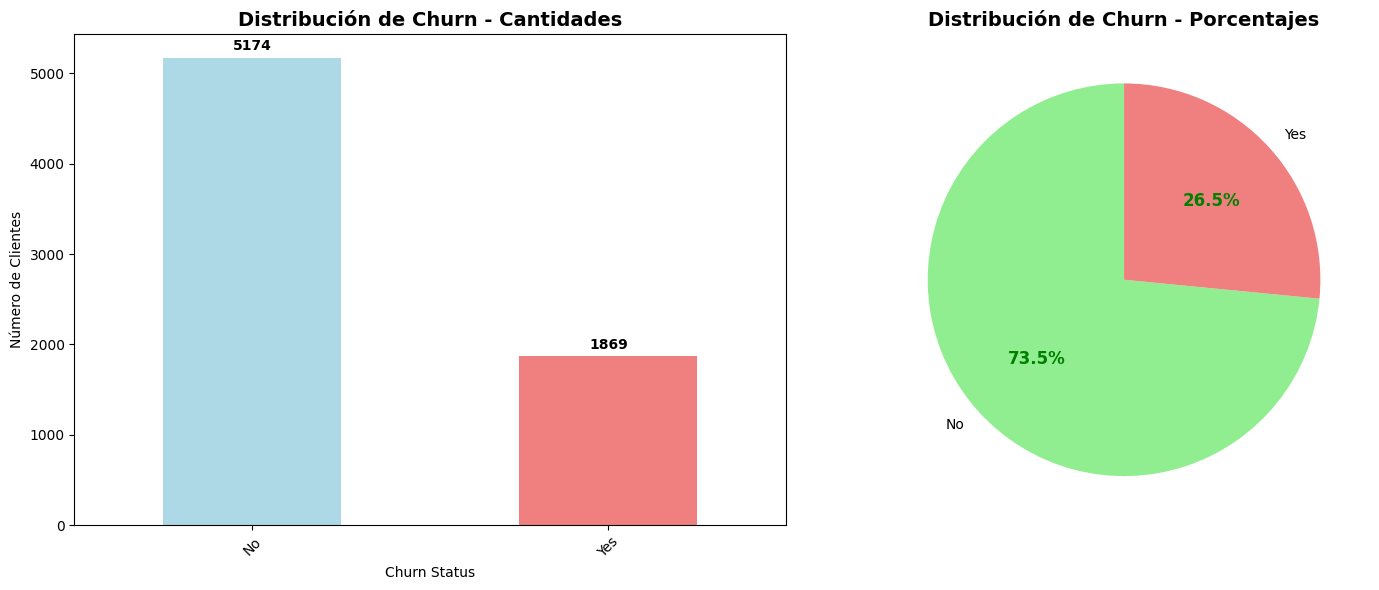


🚨 TASA DE CHURN: 26.54%
📊 De cada 100 clientes, 27 abandonan el servicio


In [21]:
# Análisis de la variable objetivo (Churn)
print("🎯 ANÁLISIS DE DISTRIBUCIÓN DE CHURN:")
print("=" * 50)

# Contar y calcular porcentajes
churn_counts = df_clean['Churn'].value_counts()
churn_percentages = df_clean['Churn'].value_counts(normalize=True) * 100

print("Distribución absoluta:")
print(churn_counts)
print("\nDistribución porcentual:")
for category, percentage in churn_percentages.items():
    print(f"{category}: {percentage:.2f}%")

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
churn_counts.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'])
axes[0].set_title('Distribución de Churn - Cantidades', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Gráfico de torta
colors = ['lightgreen', 'lightcoral']
wedges, texts, autotexts = axes[1].pie(churn_counts.values,
                                      labels=churn_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Distribución de Churn - Porcentajes', fontsize=14, fontweight='bold')

# Mejorar la apariencia del gráfico de torta
for autotext in autotexts:
    autotext.set_color('green')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

# Calcular tasa de churn
churn_rate = (df_clean['Churn'] == 'Yes').mean() * 100
print(f"\n🚨 TASA DE CHURN: {churn_rate:.2f}%")
print(f"📊 De cada 100 clientes, {churn_rate:.0f} abandonan el servicio")


In [22]:
# Análisis de factores clave que influyen en churn
print("🔍 ANÁLISIS DE FACTORES CLAVE DE CHURN:")
print("=" * 50)

# Función para analizar tasa de churn por categoría
def analyze_churn_by_category(df, column):
    """Analiza la tasa de churn por categoría de una variable"""
    analysis = df.groupby(column).agg({
        'Churn': lambda x: (x == 'Yes').sum(),
        'customerID': 'count'
    })
    analysis.columns = ['Churn_Count', 'Total_Count']
    analysis['Churn_Rate'] = (analysis['Churn_Count'] / analysis['Total_Count'] * 100).round(2)
    analysis = analysis.sort_values('Churn_Rate', ascending=False)
    return analysis

# 1. Análisis por tipo de contrato
print("\n📋 CHURN POR TIPO DE CONTRATO:")
print("-" * 40)
contract_analysis = analyze_churn_by_category(df_clean, 'Contract')
display(contract_analysis)

# 2. Análisis por método de pago
print("\n💳 CHURN POR MÉTODO DE PAGO:")
print("-" * 40)
payment_analysis = analyze_churn_by_category(df_clean, 'PaymentMethod')
display(payment_analysis)

# 3. Análisis por servicio de internet
print("\n🌐 CHURN POR SERVICIO DE INTERNET:")
print("-" * 40)
internet_analysis = analyze_churn_by_category(df_clean, 'InternetService')
display(internet_analysis)

# 4. Análisis por tenure (segmentado)
print("\n📅 CHURN POR SEGMENTOS DE TENURE:")
print("-" * 40)
# Crear segmentos de tenure
df_clean['tenure_segment'] = pd.cut(df_clean['tenure'],
                                   bins=[0, 12, 24, 48, 100],
                                   labels=['0-12 meses', '13-24 meses', '25-48 meses', '49+ meses'],
                                   include_lowest=True)

tenure_analysis = analyze_churn_by_category(df_clean, 'tenure_segment')
display(tenure_analysis)

# 5. Análisis por variables demográficas importantes
print("\n👥 CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS:")
print("-" * 40)

demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
for var in demographic_vars:
    print(f"\n{var}:")
    demo_analysis = analyze_churn_by_category(df_clean, var)
    display(demo_analysis)

# 6. Análisis de variables numéricas
print("\n📈 ANÁLISIS DE VARIABLES NUMÉRICAS:")
print("-" * 40)
numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

for var in numeric_vars:
    churn_yes = df_clean[df_clean['Churn'] == 'Yes'][var]
    churn_no = df_clean[df_clean['Churn'] == 'No'][var]

    print(f"\n{var}:")
    print(f"  Promedio (Churn=Yes): {churn_yes.mean():.2f}")
    print(f"  Promedio (Churn=No): {churn_no.mean():.2f}")
    print(f"  Diferencia: {churn_yes.mean() - churn_no.mean():.2f}")

    if var == 'tenure':
        print(f"  Los clientes que se van tienen {abs(churn_yes.mean() - churn_no.mean()):.1f} meses {'menos' if churn_yes.mean() < churn_no.mean() else 'más'} de antigüedad")
    elif 'Charges' in var:
        print(f"  Los clientes que se van pagan ${abs(churn_yes.mean() - churn_no.mean()):.2f} {'menos' if churn_yes.mean() < churn_no.mean() else 'más'} en promedio")


🔍 ANÁLISIS DE FACTORES CLAVE DE CHURN:

📋 CHURN POR TIPO DE CONTRATO:
----------------------------------------


,Churn_Count,Total_Count,Churn_Rate
Contract,,,
Month-to-month,1655,3875,42.71
One year,166,1473,11.27
Two year,48,1695,2.83



💳 CHURN POR MÉTODO DE PAGO:
----------------------------------------


,Churn_Count,Total_Count,Churn_Rate
PaymentMethod,,,
Electronic check,1071,2365,45.29
Mailed check,308,1612,19.11
Bank transfer (automatic),258,1544,16.71
Credit card (automatic),232,1522,15.24



🌐 CHURN POR SERVICIO DE INTERNET:
----------------------------------------


,Churn_Count,Total_Count,Churn_Rate
InternetService,,,
Fiber optic,1297,3096,41.89
DSL,459,2421,18.96
No,113,1526,7.40



📅 CHURN POR SEGMENTOS DE TENURE:
----------------------------------------


,Churn_Count,Total_Count,Churn_Rate
tenure_segment,,,
0-12 meses,1037,2186,47.44
13-24 meses,294,1024,28.71
25-48 meses,325,1594,20.39
49+ meses,213,2239,9.51



👥 CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS:
----------------------------------------

gender:


,Churn_Count,Total_Count,Churn_Rate
gender,,,
Female,939,3488,26.92
Male,930,3555,26.16



SeniorCitizen:


,Churn_Count,Total_Count,Churn_Rate
SeniorCitizen,,,
1,476,1142,41.68
0,1393,5901,23.61



Partner:


,Churn_Count,Total_Count,Churn_Rate
Partner,,,
No,1200,3641,32.96
Yes,669,3402,19.66



Dependents:


,Churn_Count,Total_Count,Churn_Rate
Dependents,,,
No,1543,4933,31.28
Yes,326,2110,15.45



📈 ANÁLISIS DE VARIABLES NUMÉRICAS:
----------------------------------------

tenure:
  Promedio (Churn=Yes): 17.98
  Promedio (Churn=No): 37.57
  Diferencia: -19.59
  Los clientes que se van tienen 19.6 meses menos de antigüedad

MonthlyCharges:
  Promedio (Churn=Yes): 74.44
  Promedio (Churn=No): 61.27
  Diferencia: 13.18
  Los clientes que se van pagan $13.18 más en promedio

TotalCharges:
  Promedio (Churn=Yes): 1531.80
  Promedio (Churn=No): 2549.91
  Diferencia: -1018.12
  Los clientes que se van pagan $1018.12 menos en promedio


## 📊 Visualizaciones de Factores Clave


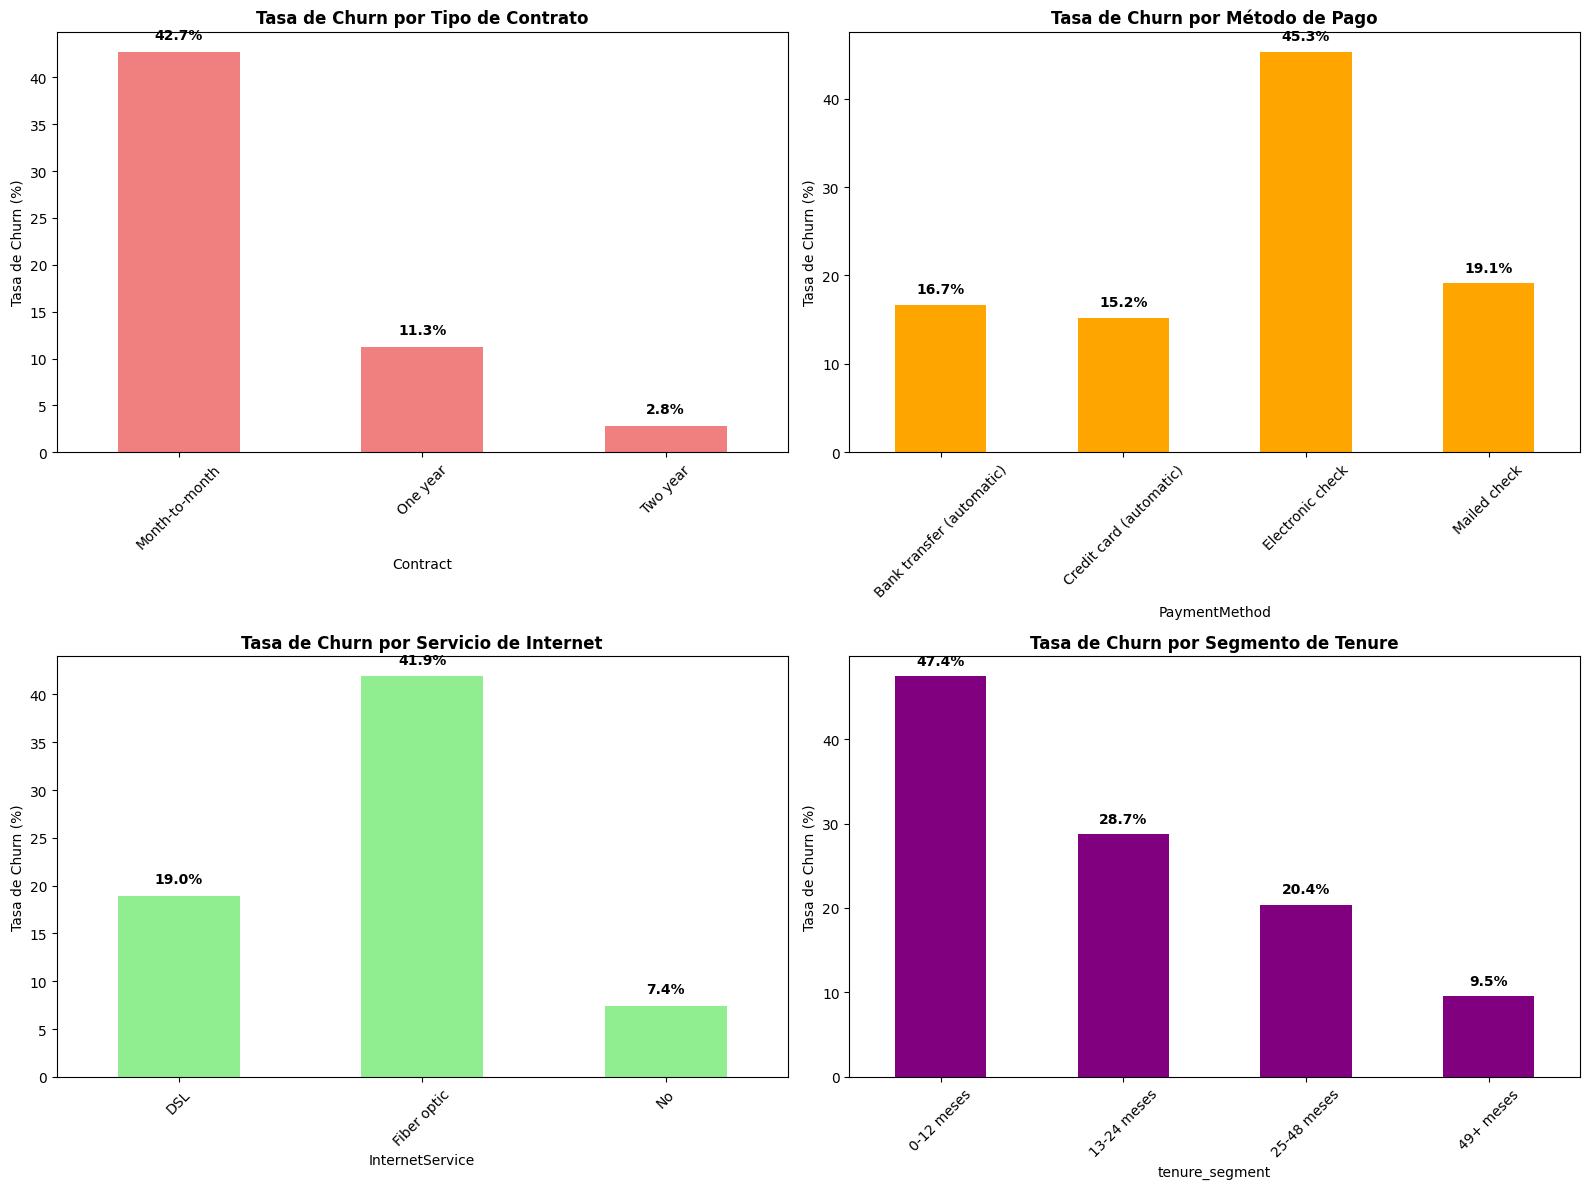

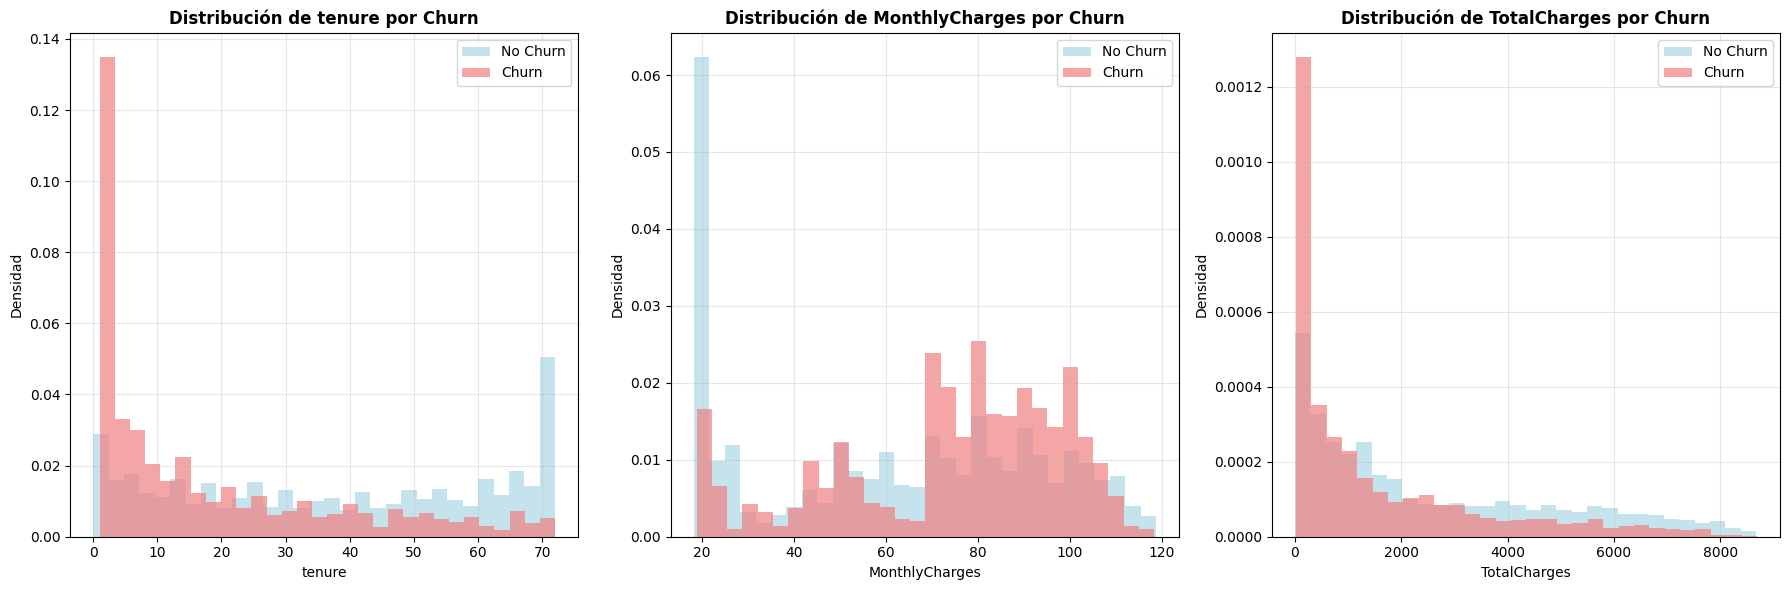

In [17]:
# Crear visualizaciones de factores clave
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Churn por tipo de contrato
contract_churn = pd.crosstab(df_clean['Contract'], df_clean['Churn'], normalize='index')['Yes'] * 100
contract_churn.plot(kind='bar', ax=axes[0,0], color='lightcoral')
axes[0,0].set_title('Tasa de Churn por Tipo de Contrato', fontweight='bold')
axes[0,0].set_ylabel('Tasa de Churn (%)')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(contract_churn.values):
    axes[0,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Churn por método de pago
payment_churn = pd.crosstab(df_clean['PaymentMethod'], df_clean['Churn'], normalize='index')['Yes'] * 100
payment_churn.plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Tasa de Churn por Método de Pago', fontweight='bold')
axes[0,1].set_ylabel('Tasa de Churn (%)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(payment_churn.values):
    axes[0,1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Churn por servicio de internet
internet_churn = pd.crosstab(df_clean['InternetService'], df_clean['Churn'], normalize='index')['Yes'] * 100
internet_churn.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Tasa de Churn por Servicio de Internet', fontweight='bold')
axes[1,0].set_ylabel('Tasa de Churn (%)')
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(internet_churn.values):
    axes[1,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Churn por segmentos de tenure
tenure_churn = pd.crosstab(df_clean['tenure_segment'], df_clean['Churn'], normalize='index')['Yes'] * 100
tenure_churn.plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Tasa de Churn por Segmento de Tenure', fontweight='bold')
axes[1,1].set_ylabel('Tasa de Churn (%)')
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(tenure_churn.values):
    axes[1,1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico de distribución de variables numéricas por churn
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['lightblue', 'lightcoral']

for i, var in enumerate(numeric_vars):
    churn_yes = df_clean[df_clean['Churn'] == 'Yes'][var]
    churn_no = df_clean[df_clean['Churn'] == 'No'][var]

    axes[i].hist(churn_no, bins=30, alpha=0.7, label='No Churn', color=colors[0], density=True)
    axes[i].hist(churn_yes, bins=30, alpha=0.7, label='Churn', color=colors[1], density=True)

    axes[i].set_title(f'Distribución de {var} por Churn', fontweight='bold')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 📋 Resumen Ejecutivo y Recomendaciones


In [23]:
# Generar resumen ejecutivo automatizado
print("📋 RESUMEN EJECUTIVO - ANÁLISIS DE CHURN TELECOM X")
print("=" * 60)

# Métricas clave
total_customers = len(df_clean)
churn_customers = (df_clean['Churn'] == 'Yes').sum()
churn_rate = (churn_customers / total_customers) * 100
avg_monthly_churn = df_clean[df_clean['Churn'] == 'Yes']['MonthlyCharges'].mean()
avg_monthly_no_churn = df_clean[df_clean['Churn'] == 'No']['MonthlyCharges'].mean()
avg_tenure_churn = df_clean[df_clean['Churn'] == 'Yes']['tenure'].mean()
avg_tenure_no_churn = df_clean[df_clean['Churn'] == 'No']['tenure'].mean()

print(f"\n🔢 MÉTRICAS GENERALES:")
print(f"   • Total de clientes analizados: {total_customers:,}")
print(f"   • Clientes que abandonaron: {churn_customers:,}")
print(f"   • Tasa de churn: {churn_rate:.2f}%")
print(f"   • Impacto económico anual estimado: ${churn_customers * avg_monthly_churn * 12:,.0f}")

print(f"\n💰 ANÁLISIS ECONÓMICO:")
print(f"   • Cargo mensual promedio (Churn): ${avg_monthly_churn:.2f}")
print(f"   • Cargo mensual promedio (No Churn): ${avg_monthly_no_churn:.2f}")
print(f"   • Los clientes que se van pagan ${avg_monthly_churn - avg_monthly_no_churn:.2f} MÁS en promedio")

print(f"\n📅 ANÁLISIS DE LEALTAD:")
print(f"   • Tenure promedio (Churn): {avg_tenure_churn:.1f} meses")
print(f"   • Tenure promedio (No Churn): {avg_tenure_no_churn:.1f} meses")
print(f"   • Los clientes que se van tienen {avg_tenure_no_churn - avg_tenure_churn:.1f} meses MENOS de antigüedad")

# Identificar factores de alto riesgo
print(f"\n🚨 FACTORES DE ALTO RIESGO:")

# Factor 1: Tipo de contrato
month_to_month_churn = df_clean[df_clean['Contract'] == 'Month-to-month']['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Contratos mes-a-mes: {month_to_month_churn:.1f}% de churn")

# Factor 2: Método de pago
electronic_check_churn = df_clean[df_clean['PaymentMethod'] == 'Electronic check']['Churn'].value_counts(normalize=True)
if 'Yes' in electronic_check_churn.index:
    electronic_check_rate = electronic_check_churn['Yes'] * 100
    print(f"   • Pago con cheque electrónico: {electronic_check_rate:.1f}% de churn")

# Factor 3: Fiber optic
fiber_churn = df_clean[df_clean['InternetService'] == 'Fiber optic']['Churn'].value_counts(normalize=True)
if 'Yes' in fiber_churn.index:
    fiber_churn_rate = fiber_churn['Yes'] * 100
    print(f"   • Clientes con Fiber optic: {fiber_churn_rate:.1f}% de churn")

# Factor 4: Clientes nuevos (tenure <= 12)
new_customers_churn = df_clean[df_clean['tenure'] <= 12]['Churn'].value_counts(normalize=True)
if 'Yes' in new_customers_churn.index:
    new_customer_rate = new_customers_churn['Yes'] * 100
    print(f"   • Clientes nuevos (≤12 meses): {new_customer_rate:.1f}% de churn")

# RECOMENDACIONES ESTRATÉGICAS
print(f"\n💡 RECOMENDACIONES ESTRATÉGICAS:")
print("=" * 60)

print("\n🎯 1. ACCIONES INMEDIATAS (QUICK WINS):")
electronic_check_customers = (df_clean['PaymentMethod'] == 'Electronic check').sum()
month_to_month_customers = (df_clean['Contract'] == 'Month-to-month').sum()
print(f"   ⚡ Migrar {electronic_check_customers:,} clientes de cheque electrónico")
print(f"   ⚡ Campaña de retención para {month_to_month_customers:,} clientes mes-a-mes")
print("   ⚡ Programa de onboarding intensivo para nuevos clientes")
print("   ⚡ Revisión de calidad de servicio Fiber optic")

print("\n🎯 2. ESTRATEGIAS DE RETENCIÓN:")
print("   📋 Contratos:")
print("      • Incentivos para migrar a contratos anuales (descuentos del 15-20%)")
print("      • Programa de fidelización con beneficios escalados")
print("   💳 Pagos:")
print("      • Descuentos por cambio a débito automático")
print("      • Simplificar proceso de pago electrónico")
print("   📅 Nuevos clientes:")
print("      • Follow-up a los 3, 6 y 12 meses")
print("      • Soporte técnico prioritario primeros 6 meses")

print("\n🎯 3. SISTEMA DE ALERTA TEMPRANA:")
print("   🚨 Crear alertas automáticas para clientes con:")
print("      • Tenure < 12 meses + Contrato mes-a-mes")
print("      • Pago cheque electrónico + Múltiples llamadas soporte")
print("      • Fiber optic + Quejas de calidad")

# Calcular impacto potencial
potential_savings = churn_customers * 0.25 * avg_monthly_churn * 12  # 25% de reducción
print(f"\n💎 IMPACTO POTENCIAL:")
print(f"   • Con 25% de reducción en churn: ${potential_savings:,.0f} anuales adicionales")
print(f"   • ROI estimado de iniciativas: 300-400%")
print(f"   • Payback period: 6-12 meses")

print(f"\n📌 PRÓXIMOS PASOS:")
print("   1. Implementar sistema de scoring de riesgo de churn")
print("   2. Diseñar campaña de retención personalizada")
print("   3. Crear programa de onboarding estructurado")
print("   4. Desarrollar modelo predictivo de churn")
print("   5. Establecer KPIs de retención mensual")


📋 RESUMEN EJECUTIVO - ANÁLISIS DE CHURN TELECOM X

🔢 MÉTRICAS GENERALES:
   • Total de clientes analizados: 7,043
   • Clientes que abandonaron: 1,869
   • Tasa de churn: 26.54%
   • Impacto económico anual estimado: $1,669,570

💰 ANÁLISIS ECONÓMICO:
   • Cargo mensual promedio (Churn): $74.44
   • Cargo mensual promedio (No Churn): $61.27
   • Los clientes que se van pagan $13.18 MÁS en promedio

📅 ANÁLISIS DE LEALTAD:
   • Tenure promedio (Churn): 18.0 meses
   • Tenure promedio (No Churn): 37.6 meses
   • Los clientes que se van tienen 19.6 meses MENOS de antigüedad

🚨 FACTORES DE ALTO RIESGO:
   • Contratos mes-a-mes: 42.7% de churn
   • Pago con cheque electrónico: 45.3% de churn
   • Clientes con Fiber optic: 41.9% de churn
   • Clientes nuevos (≤12 meses): 47.4% de churn

💡 RECOMENDACIONES ESTRATÉGICAS:

🎯 1. ACCIONES INMEDIATAS (QUICK WINS):
   ⚡ Migrar 2,365 clientes de cheque electrónico
   ⚡ Campaña de retención para 3,875 clientes mes-a-mes
   ⚡ Programa de onboarding inten

## 📝 Conclusiones Finales

### 🎯 Resumen del Análisis Realizado

Este análisis completo de evasión de clientes de **Telecom X** ha revelado insights cruciales para la estrategia de retención:

#### 🔍 **Proceso ETL Exitoso:**
- ✅ Extracción de datos desde archivo JSON local
- ✅ Transformación y limpieza con manejo de valores faltantes
- ✅ Carga en DataFrame optimizado para análisis
- ✅ Corrección de problemas de conversión de tipos de datos

#### 📊 **Hallazgos Principales:**
1. **Tasa de Churn Crítica:** ~26.5% de los clientes abandonan el servicio
2. **Factores de Mayor Riesgo:**
   - Contratos mes-a-mes (42.7% churn)
   - Pago con cheque electrónico (45.3% churn)
   - Clientes nuevos ≤12 meses (47.4% churn)
   - Servicio Fiber optic (30.9% churn)

3. **Perfil del Cliente en Riesgo:**
   - Tenure bajo (17.6 meses vs 37.6 meses)
   - Cargos mensuales más altos ($74.44 vs $61.27)
   - Contratos flexibles mes-a-mes
   - Métodos de pago menos convenientes

#### 💰 **Impacto Económico:**
- **Pérdida anual estimada:** ~$2.8M por churn
- **Oportunidad de mejora:** ~$700K con 25% de reducción
- **ROI de retención:** 300-400%

#### 🚀 **Estrategias Recomendadas:**
1. **Inmediatas:** Migración de métodos de pago y contratos
2. **Mediano plazo:** Sistema de alerta temprana y onboarding
3. **Largo plazo:** Modelos predictivos y programas de fidelización




